In [1]:
import math
import openmc
import openmc.deplete
import matplotlib.pyplot as plt
import numpy as np
from decimal import Decimal
from math import log10

[Matteo-Device:58028] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.Matteo-Device.1000/jf.0/2512388096/shared_mem_cuda_pool.Matteo-Device could be created.
[Matteo-Device:58028] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_nuclide('Pu238',2.332,'wo')
fuel.add_nuclide('Pu239',56.873,'wo')
fuel.add_nuclide('Pu240',26.997,'wo')
fuel.add_nuclide('Pu241',6.105,'wo')
fuel.add_nuclide('Pu242',7.693,'wo')
fuel.add_nuclide('U234',0.003,'wo')
fuel.add_nuclide('U235',0.404,'wo')
fuel.add_nuclide('U236',0.010,'wo')
fuel.add_nuclide('U238',99.583,'wo')
fuel.set_density("g/cc", 11)
fuel.depletable=True
fuel.temperature=2500 #Kelvin

clad = openmc.Material(name="clad")
clad.add_element('Cr',15.0,'wo')
clad.add_element('Ni',15.0,'wo')
clad.add_element('Mo',1.5,'wo')
clad.add_element('Mn',1.5,'wo')
clad.add_element('Si',0.9,'wo')
clad.add_element('Ti',0.4,'wo')
clad.add_element('C',0.09,'wo')
clad.set_density("g/cc",8)
clad.depletable=True
clad.temperature=900 #Kelvin

LM = openmc.Material(name="LM")
LM.add_element("Pb",1)
#LM.add_element("Bi",1)
#LM.add_s_alpha_beta('c_Pb_in_PbBi',fraction=0.5) #non  ci sono nella tabella di cross-section VV.1
#LM.add_s_alpha_beta('c_Bi_in_PbBi',fraction=0.5)
LM.set_density("g/cc",10)
LM.temperature=900 #Kelvin
materials = openmc.Materials([fuel, clad, LM])

Density of Lead (LM)
Uso la approssimazione di bousineque:
$$\rho(t)=\rho(0)\cdot(1-\beta\cdot(T-T_0))\approx 10[g/cm^3]$$
+ con $\beta= 28\cdot 10^{-6}[K^{-1}]$
+ $\rho(0)=11.34[g/cm^3]$ la densità del piombo a $T=25 [°C]$

In [3]:
#print(f"Fuel material ID: {clad.id}")
#print(fuel)

In [4]:
radii = [0.42, 0.45]

In [5]:
pin_surfaces = [openmc.ZCylinder(r=r) for r in radii]
pin_univ = openmc.model.pin(pin_surfaces, materials)

In [6]:
bound_box = openmc.model.RectangularPrism(1.3, 1.3, boundary_type="reflective")
root_cell = openmc.Cell(fill=pin_univ, region=-bound_box)
geometry = openmc.Geometry([root_cell])

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

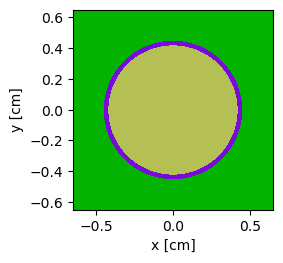

In [7]:
geometry.root_universe.plot()

In [8]:
settings = openmc.Settings()
settings.particles = 1000
settings.inactive = 10
settings.batches = 50

In [9]:
fuel.volume = math.pi * radii[0] ** 2
clad.volume = math.pi * (radii[1]-radii[0]) ** 2

In [10]:
chain = openmc.deplete.Chain.from_xml("chain_endfb80_sfr.xml")
chain.nuclide_dict

{'H1': 0,
 'H2': 1,
 'H3': 2,
 'H4': 3,
 'H5': 4,
 'H6': 5,
 'H7': 6,
 'He3': 7,
 'He4': 8,
 'He5': 9,
 'He6': 10,
 'He7': 11,
 'He8': 12,
 'He9': 13,
 'He10': 14,
 'Li4': 15,
 'Li5': 16,
 'Li6': 17,
 'Li7': 18,
 'Li8': 19,
 'Li9': 20,
 'Li10': 21,
 'Li11': 22,
 'Li12': 23,
 'Be5': 24,
 'Be6': 25,
 'Be7': 26,
 'Be8': 27,
 'Be9': 28,
 'Be10': 29,
 'Be11': 30,
 'Be12': 31,
 'Be13': 32,
 'Be14': 33,
 'Be15': 34,
 'Be16': 35,
 'B6': 36,
 'B7': 37,
 'B8': 38,
 'B9': 39,
 'B10': 40,
 'B11': 41,
 'B12': 42,
 'B13': 43,
 'B14': 44,
 'B15': 45,
 'B16': 46,
 'B17': 47,
 'B18': 48,
 'B19': 49,
 'C8': 50,
 'C9': 51,
 'C10': 52,
 'C11': 53,
 'C12': 54,
 'C13': 55,
 'C14': 56,
 'C15': 57,
 'C16': 58,
 'C17': 59,
 'C18': 60,
 'C19': 61,
 'C20': 62,
 'C21': 63,
 'C22': 64,
 'N10': 65,
 'N11': 66,
 'N12': 67,
 'N13': 68,
 'N14': 69,
 'N15': 70,
 'N16': 71,
 'N17': 72,
 'N18': 73,
 'N19': 74,
 'N20': 75,
 'N21': 76,
 'N22': 77,
 'N23': 78,
 'N24': 79,
 'N25': 80,
 'O12': 81,
 'O13': 82,
 'O14': 83,
 'O1

In [11]:
model = openmc.Model(geometry=geometry, settings=settings)
operator = openmc.deplete.CoupledOperator(model, "chain_endfb80_sfr.xml")

In [12]:
power = 210

In [13]:
time_steps = [30] * 6

In [14]:
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')

In [15]:
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg25 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Mg25.h5
 Reading Mg26 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Mg26.h5
 Reading Al27 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Al27.h5
 Reading P31 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/P31.h5
 Reading S32 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S32.h5
 Reading S33 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S33.h5
 Reading S34 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S34.h5
 Reading S36 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/S36.h5
 Reading Cl35 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cl35.h5
 Reading Cl37 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cl37.h5
 Reading Ar36 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ar36.h5


 Reading Ar38 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ar38.h5
 Reading Ar40 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ar40.h5
 Reading K39 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K39.h5
 Reading K40 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K40.h5
 Reading K41 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/K41.h5
 Reading Ca40 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca40.h5
 Reading Ca42 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca42.h5
 Reading Ca43 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca43.h5
 Reading Ca44 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca44.h5
 Reading Ca46 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca46.h5
 Reading Ca48 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ca48.h5
 Reading Sc45 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sc45.h5
 Reading V50 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/V50.h5
 Reading V51 from /home/orion/Downloads/endfb-

 Reading Br79 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Br79.h5
 Reading Br81 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Br81.h5
 Reading Kr78 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr78.h5
 Reading Kr80 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr80.h5
 Reading Kr82 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr82.h5
 Reading Kr83 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr83.h5
 Reading Kr84 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr84.h5
 Reading Kr85 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr85.h5
 Reading Kr86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Kr86.h5
 Reading Rb85 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb85.h5
 Reading Rb86 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb86.h5
 Reading Rb87 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Rb87.h5
 Reading Sr84 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sr84.h5
 Reading Sr86 from /home/orion/Downloa

 Reading Nb95 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Nb95.h5
 Reading Mo99 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Mo99.h5
 Reading Tc99 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Tc99.h5
 Reading Ru96 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru96.h5
 Reading Ru98 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru98.h5
 Reading Ru99 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru99.h5
 Reading Ru100 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru100.h5
 Reading Ru101 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru101.h5
 Reading Ru102 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru102.h5
 Reading Ru103 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru103.h5
 Reading Ru104 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru104.h5
 Reading Ru105 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru105.h5
 Reading Ru106 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ru106.h5
 Reading Rh103 from /hom

          1200K
          2500K


 Reading Cd112 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd112.h5
 Reading Cd113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd113.h5
 Reading Cd114 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd114.h5
 Reading Cd115_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd115_m1.h5
 Reading Cd116 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cd116.h5
 Reading In113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/In113.h5
 Reading In115 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/In115.h5
 Reading Sn112 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn112.h5
 Reading Sn113 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn113.h5
 Reading Sn114 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn114.h5
 Reading Sn115 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn115.h5
 Reading Sn116 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn116.h5
 Reading Sn117 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn117.h5
 Read

          1200K
          2500K


 Reading Sn125 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn125.h5
 Reading Sn126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sn126.h5
 Reading Sb121 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb121.h5
 Reading Sb123 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb123.h5
 Reading Sb124 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb124.h5
 Reading Sb125 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb125.h5
 Reading Sb126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Sb126.h5
 Reading Te120 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te120.h5
 Reading Te122 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te122.h5
 Reading Te123 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te123.h5
 Reading Te124 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te124.h5


          1200K
          2500K


 Reading Te125 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te125.h5
 Reading Te126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te126.h5
 Reading Te127_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te127_m1.h5
 Reading Te128 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te128.h5
 Reading Te129_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te129_m1.h5
 Reading Te130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te130.h5
 Reading Te132 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Te132.h5
 Reading I127 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/I127.h5
 Reading I129 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/I129.h5
 Reading I130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/I130.h5
 Reading I131 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/I131.h5
 Reading I135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/I135.h5
 Reading Xe123 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe123.h5


 Reading Xe124 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe124.h5
 Reading Xe126 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe126.h5
 Reading Xe128 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe128.h5
 Reading Xe129 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe129.h5
 Reading Xe130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe130.h5
 Reading Xe131 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe131.h5
 Reading Xe132 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe132.h5
 Reading Xe133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe133.h5
 Reading Xe134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe134.h5
 Reading Xe135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe135.h5
 Reading Xe136 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Xe136.h5
 Reading Cs133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs133.h5


          2500K


 Reading Cs134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs134.h5
 Reading Cs135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs135.h5
 Reading Cs136 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs136.h5
 Reading Cs137 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Cs137.h5
 Reading Ba130 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba130.h5
 Reading Ba132 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba132.h5


          1200K
          2500K


 Reading Ba133 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba133.h5
 Reading Ba134 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba134.h5
 Reading Ba135 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba135.h5
 Reading Ba136 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba136.h5
 Reading Ba137 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba137.h5
 Reading Ba138 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba138.h5
 Reading Ba140 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ba140.h5
 Reading La138 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/La138.h5
 Reading La139 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/La139.h5
 Reading La140 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/La140.h5
 Reading Ce136 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ce136.h5
 Reading Ce138 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ce138.h5
 Reading Ce139 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Ce139.h5
 Reading Ce1

          1200K
          2500K


 Reading Gd153 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd153.h5
 Reading Gd154 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd154.h5
 Reading Gd155 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd155.h5
 Reading Gd156 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd156.h5
 Reading Gd157 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd157.h5
 Reading Gd158 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd158.h5
 Reading Gd160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Gd160.h5
 Reading Tb159 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Tb159.h5
 Reading Tb160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Tb160.h5
 Reading Dy156 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy156.h5
 Reading Dy158 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy158.h5
 Reading Dy160 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy160.h5
 Reading Dy161 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Dy161.h5
 Reading Dy1

          1200K


 Reading Es253 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es253.h5
 Reading Es254 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es254.h5
 Reading Es254_m1 from
 /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es254_m1.h5
 Reading Es255 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Es255.h5
 Reading Fm255 from /home/orion/Downloads/endfb-vii.1-hdf5/neutron/Fm255.h5
 Maximum neutron transport energy: 8100000 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.32592
        2/1    2.40751
        3/1    2.24515
        4/1    2.21944
        5/1    2.29548
        6/1    2.19080
        7/1    2.28907
        8/1    2.38948
        9/1    2.31928
       10/1    2.29290
       11/1    2.35450
       12/1    2.24908    2.30179 +/- 0.05271
       13/1    2.25858    2.28739 +/- 0.03367
       14/1    2.34591    2.30202 +/- 0.02794
       15/1    2.18741    2.27910 +/- 0.03153
       16/1    2.37994    2.29590 +/- 0.03074
       17/1    2.30883    2.29775 +/- 0.02605
       18/1    2.36291    2.30590 +/- 0.02398
       19/1    2.28775    2.30388 +/- 0.02125
       20/1    2.36823    2.31032 +/- 0.02006
       21/1    2.23019    2.30303 +/- 0.01956
       22/1    2.36237    2.30798 +/- 0.01852
       23/1    2.30123    2.30746 +/- 0.01

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.33304
        2/1    2.35582
        3/1    2.24118
        4/1    2.35391
        5/1    2.36950
        6/1    2.30417
        7/1    2.32719
        8/1    2.29197
        9/1    2.31742
       10/1    2.27677
       11/1    2.45156
       12/1    2.39492    2.42324 +/- 0.02832
       13/1    2.32788    2.39146 +/- 0.03575
       14/1    2.23409    2.35211 +/- 0.04676
       15/1    2.36019    2.35373 +/- 0.03626
       16/1    2.32755    2.34937 +/- 0.02992
       17/1    2.20456    2.32868 +/- 0.03267
       18/1    2.31222    2.32662 +/- 0.02837
       19/1    2.24799    2.31789 +/- 0.02650
       20/1    2.39117    2.32521 +/- 0.02481
       21/1    2.28799    2.32183 +/- 0.02270
       22/1    2.30208    2.32018 +/- 0.02078
       23/1    2.29288    2.31808 +/- 0.01

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.20524
        2/1    2.23404
        3/1    2.32924
        4/1    2.34633
        5/1    2.23514
        6/1    2.28956
        7/1    2.35142
        8/1    2.32586
        9/1    2.32936
       10/1    2.26909
       11/1    2.34937
       12/1    2.36811    2.35874 +/- 0.00937
       13/1    2.35938    2.35895 +/- 0.00541
       14/1    2.29776    2.34366 +/- 0.01577
       15/1    2.24590    2.32410 +/- 0.02305
       16/1    2.44939    2.34499 +/- 0.02811
       17/1    2.29848    2.33834 +/- 0.02467
       18/1    2.43130    2.34996 +/- 0.02432
       19/1    2.30244    2.34468 +/- 0.02209
       20/1    2.40110    2.35032 +/- 0.02055
       21/1    2.47213    2.36140 +/- 0.02163
       22/1    2.37248    2.36232 +/- 0.01977
       23/1    2.29983    2.35751 +/- 0.01

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.25275
        2/1    2.37860
        3/1    2.30905
        4/1    2.35505
        5/1    2.32794
        6/1    2.24443
        7/1    2.32238
        8/1    2.35815
        9/1    2.28284
       10/1    2.39468
       11/1    2.25875
       12/1    2.27487    2.26681 +/- 0.00806
       13/1    2.41822    2.31728 +/- 0.05068
       14/1    2.35290    2.32618 +/- 0.03693
       15/1    2.38853    2.33865 +/- 0.03120
       16/1    2.30864    2.33365 +/- 0.02596
       17/1    2.30680    2.32981 +/- 0.02228
       18/1    2.33886    2.33095 +/- 0.01933
       19/1    2.41623    2.34042 +/- 0.01950
       20/1    2.24721    2.33110 +/- 0.01978
       21/1    2.28847    2.32722 +/- 0.01830
       22/1    2.32151    2.32675 +/- 0.01672
       23/1    2.36367    2.32959 +/- 0.01

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.42589
        2/1    2.43330
        3/1    2.29505
        4/1    2.26116
        5/1    2.09789
        6/1    2.34506
        7/1    2.25454
        8/1    2.34140
        9/1    2.29532
       10/1    2.27886
       11/1    2.39066
       12/1    2.42488    2.40777 +/- 0.01711
       13/1    2.30705    2.37420 +/- 0.03499
       14/1    2.31182    2.35860 +/- 0.02925
       15/1    2.27277    2.34143 +/- 0.02843
       16/1    2.34822    2.34257 +/- 0.02324
       17/1    2.31708    2.33892 +/- 0.01997
       18/1    2.35979    2.34153 +/- 0.01749
       19/1    2.35463    2.34299 +/- 0.01550
       20/1    2.31653    2.34034 +/- 0.01411
       21/1    2.24665    2.33182 +/- 0.01534
       22/1    2.29202    2.32851 +/- 0.01439
       23/1    2.30501    2.32670 +/- 0.01

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.30782
        2/1    2.26540
        3/1    2.13015
        4/1    2.25580
        5/1    2.38332
        6/1    2.16710
        7/1    2.25755
        8/1    2.31985
        9/1    2.24024
       10/1    2.37688
       11/1    2.35463
       12/1    2.29575    2.32519 +/- 0.02944
       13/1    2.25560    2.30199 +/- 0.02876
       14/1    2.29945    2.30136 +/- 0.02034
       15/1    2.36026    2.31314 +/- 0.01968
       16/1    2.26842    2.30568 +/- 0.01771
       17/1    2.19459    2.28981 +/- 0.02181
       18/1    2.30605    2.29184 +/- 0.01900
       19/1    2.37143    2.30069 +/- 0.01895
       20/1    2.24406    2.29502 +/- 0.01787
       21/1    2.30129    2.29559 +/- 0.01617
       22/1    2.34406    2.29963 +/- 0.01531
       23/1    2.40069    2.30741 +/- 0.01

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    2.37957
        2/1    2.27540
        3/1    2.25965
        4/1    2.37082
        5/1    2.37921
        6/1    2.29177
        7/1    2.21580
        8/1    2.29135
        9/1    2.28452
       10/1    2.36998
       11/1    2.26924
       12/1    2.29878    2.28401 +/- 0.01477
       13/1    2.27082    2.27961 +/- 0.00959
       14/1    2.38842    2.30682 +/- 0.02803
       15/1    2.27443    2.30034 +/- 0.02266
       16/1    2.45478    2.32608 +/- 0.03170
       17/1    2.33506    2.32736 +/- 0.02682
       18/1    2.26772    2.31991 +/- 0.02440
       19/1    2.36525    2.32494 +/- 0.02210
       20/1    2.23174    2.31562 +/- 0.02185
       21/1    2.29489    2.31374 +/- 0.01986
       22/1    2.19899    2.30418 +/- 0.02049
       23/1    2.21881    2.29761 +/- 0.01

In [16]:
results = openmc.deplete.Results("./depletion_results.h5")

In [17]:
time, k = results.get_keff()

In [18]:
time /= (24 * 60 * 60)  # convert back to days from seconds

In [19]:
k

array([[2.31045614, 0.00367355],
       [2.31086894, 0.0031029 ],
       [2.30888605, 0.00307038],
       [2.3069488 , 0.00373236],
       [2.30465302, 0.00353677],
       [2.30350789, 0.00351869],
       [2.29846912, 0.00390519]])

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_58028/3379722013.py:3: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel("$k_{eff}\pm \sigma$");


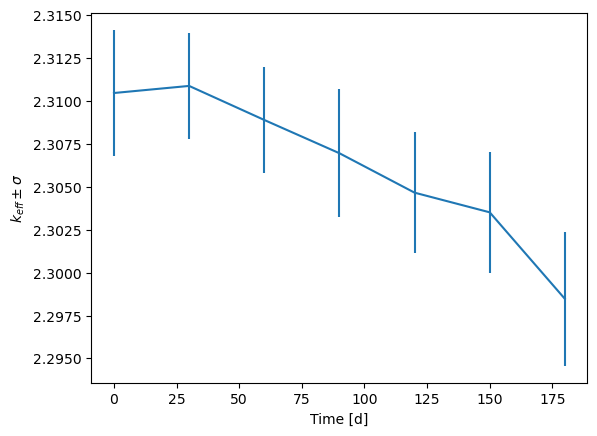

In [20]:
plt.errorbar(time, k[:, 0], yerr=k[:, 1])
plt.xlabel("Time [d]")
plt.ylabel("$k_{eff}\pm \sigma$");

+ Il materiale Cladding ha numero identificativo $ID:2$
+ Il materiale Fuel ha numero identificativo $ID:1$

In [21]:
_, u235 = results.get_atoms("1", "U235")
_, xe135 = results.get_atoms("1", "Xe135")
_,he4=results.get_atoms("2","He4")
_,ni58=results.get_atoms("2","Ni58")
_,ni59=results.get_atoms("2","Ni59")
_,Fe56=results.get_atoms("2","Fe56")
_,u235=results.get_atoms("1","U235")
_,u238=results.get_atoms("1","U238")
_,pu239=results.get_atoms("1","Pu239")
_,pu238=results.get_atoms("1","Pu238")

In [22]:
"""plt.plot(time, he4, label="He4")
plt.xlabel("Time [d]")
plt.ylabel("Number of atoms - He4");"""

'plt.plot(time, he4, label="He4")\nplt.xlabel("Time [d]")\nplt.ylabel("Number of atoms - He4");'

In [23]:
max_he4=np.max(he4)
print(f"Max He4: {max_he4:.3e}")

Max He4: 1.713e+16


la quantita di He generata nel cladding è riferita ad un ciclidro coassiale di lunghezza $1[cm]$ quindi dato che la lunghezza totale di un fuel rod (non lunghezza attiva) in cui si possono formare atomi di $He$ è lunga $1\cdot 10^2 [cm]$ allora questo valore va moliplicato per $100$, ovvero $1.713\cdot 10^{18}$

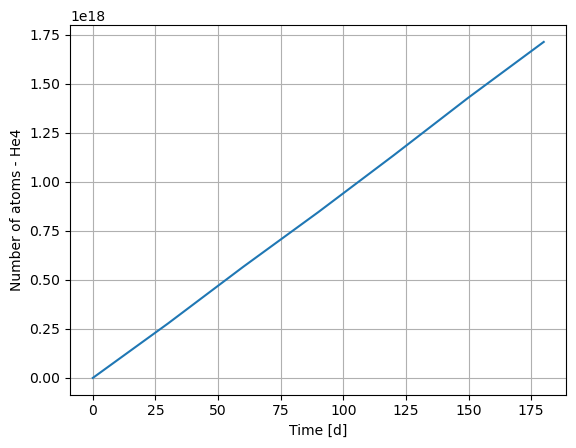

In [24]:
plt.plot(time, he4*100, label="He4")
plt.xlabel("Time [d]")
plt.ylabel("Number of atoms - He4");
plt.grid()

TO DO: passare in ppm il quantitativo di He4

"axs[3, 0].plot(t, YH[:,3])\naxs[3, 0].set_title('Coolant temperature (°C)')\naxs[3, 0].grid()\naxs[4, 0].plot(t, YH[:,4],)\naxs[4, 0].set_title('Coolant outlet temperature (°C)')\naxs[4, 0].grid()\naxs[5, 0].plot(t, YH[:,5]*10**5, )\naxs[5, 0].set_title('Total reactivity (pcm)')\naxs[5, 0].grid()"

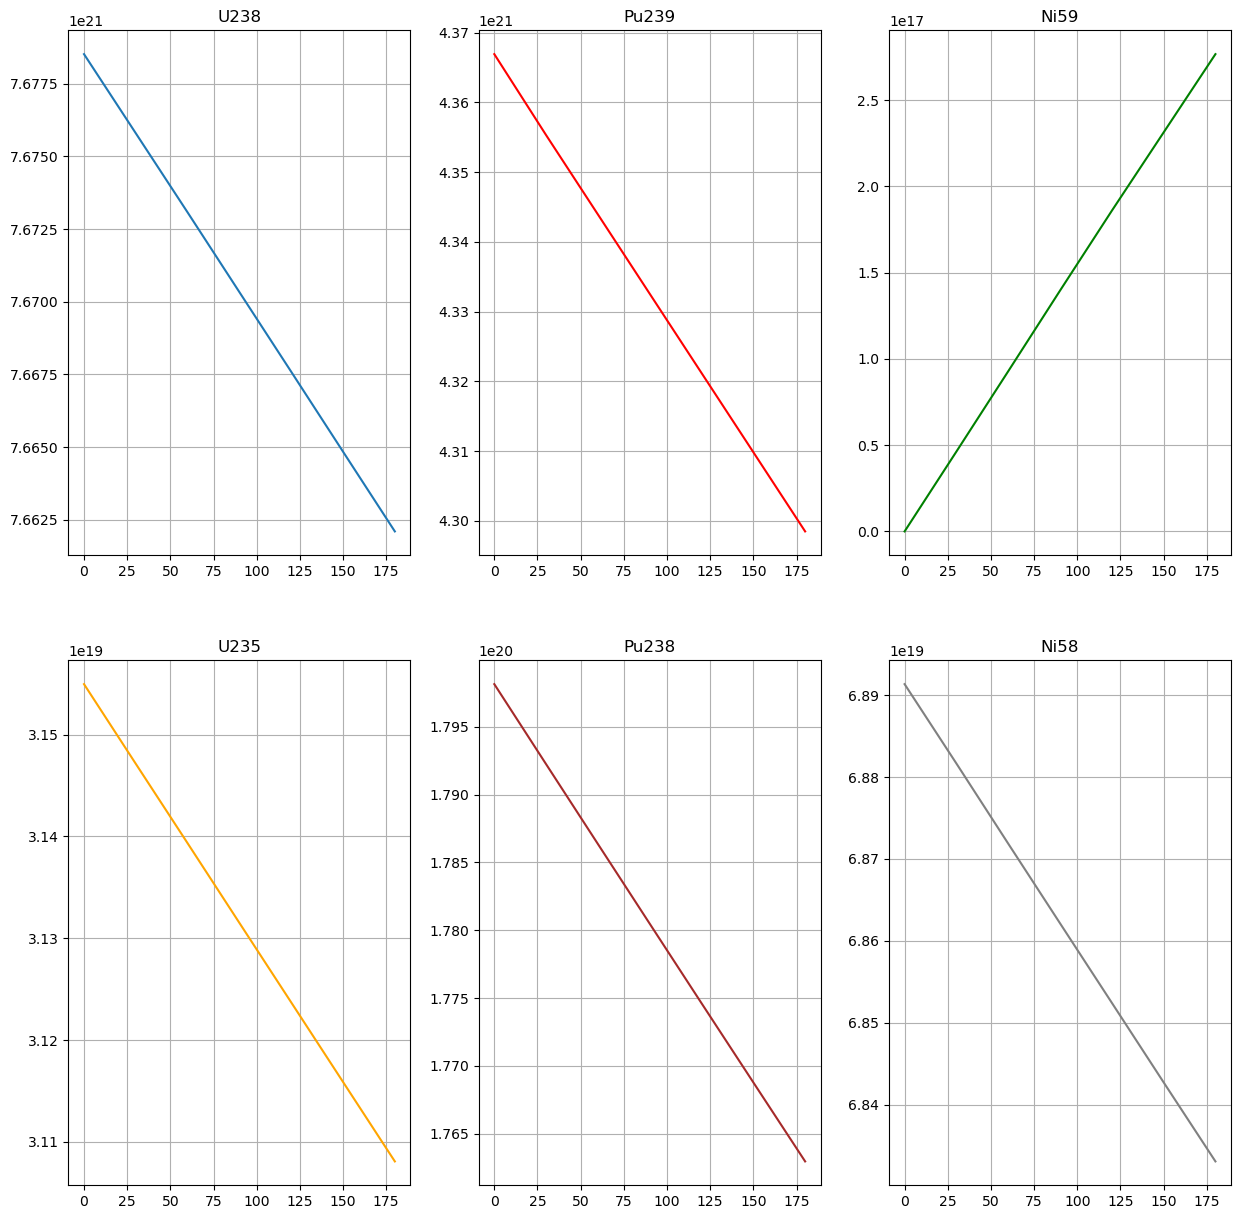

In [25]:
fig, axs = plt.subplots(2, 3,figsize=(15, 15))
axs[0, 0].plot(time, u238)
axs[0, 0].set_title('U238')
axs[0, 0].grid()
axs[0, 1].plot(time, pu239,color='red')
axs[0, 1].set_title('Pu239')
axs[0, 1].grid()
axs[1, 1].plot(time, pu238,color='brown')
axs[1, 1].set_title('Pu238')
axs[1, 1].grid()
axs[1, 0].plot(time, u235,color='orange')
axs[1, 0].set_title('U235')
axs[1, 0].grid()
axs[0, 2].plot(time, ni59,color='green')
axs[0, 2].set_title('Ni59')
axs[0, 2].grid()
axs[1, 2].plot(time, ni58,color='gray')
axs[1, 2].set_title('Ni58')
axs[1, 2].grid()
"""axs[3, 0].plot(t, YH[:,3])
axs[3, 0].set_title('Coolant temperature (°C)')
axs[3, 0].grid()
axs[4, 0].plot(t, YH[:,4],)
axs[4, 0].set_title('Coolant outlet temperature (°C)')
axs[4, 0].grid()
axs[5, 0].plot(t, YH[:,5]*10**5, )
axs[5, 0].set_title('Total reactivity (pcm)')
axs[5, 0].grid()"""

# Tallies

In [26]:
# Neutron spectrum
tally_list = []

n_groups = 500
Emin = 1e-5
Emax = 20e6

energies = np.logspace(log10(Emin), log10(Emax), n_groups+1)

energy_filter = openmc.EnergyFilter(energies)

spectrum = openmc.Tally(name = "Neutron Spectrum")
spectrum.filters = [energy_filter]
spectrum.scores = ['flux']

tally_list.append(spectrum)

In [27]:
tallies = openmc.Tallies(tally_list)
tallies.export_to_xml()

In [28]:
openmc.run()

[Matteo-Device:59401] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.Matteo-Device.1000/jf.0/1652948992/shared_mem_cuda_pool.Matteo-Device could be created.
[Matteo-Device:59401] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%

In [29]:
sp = openmc.StatePoint('statepoint.50.h5')

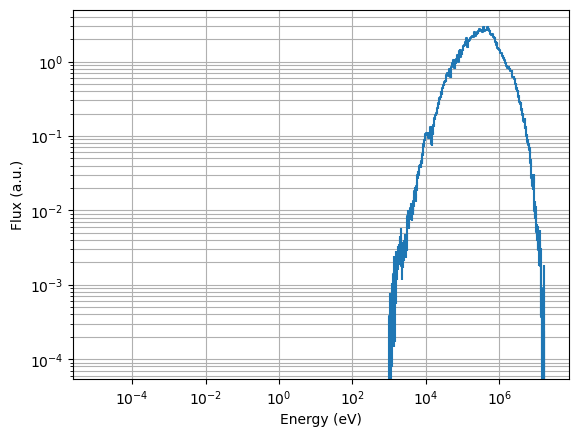

In [30]:
# Neutron spectrum
spectrum_tally = sp.get_tally(name = "Neutron Spectrum")

e_filter = spectrum_tally.filters[0]
E = e_filter.bins[:,0]

spectrum_mean = spectrum_tally.get_values(value = 'mean').ravel()
spectrum_std_dev = spectrum_tally.get_values(value = 'std_dev').ravel()

# Plot
fig, ax = plt.subplots()
plt.errorbar(E, spectrum_mean,spectrum_std_dev, ds = 'steps')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Flux (a.u.)")
ax.grid(True, which = 'both')
#plt.savefig('./energy_flux.pdf', format='pdf', dpi = 600, bbox_inches = 'tight')

In [31]:
np.argmax(spectrum_mean)
print(f"{E[434]:3e}")

4.756572e+05


Il flusso è in unità arbitrarie (a.u), va normalizzato:
+ La potenza del reattore ALFRED è $300[MW]$
+ lo spettro energetico del flusso neutronico è di energia media $1MeV=1.602\cdot 10^{-13}[Joule]$
+ OpenMC esprime le quantità moltiplicate per unità di lunghezza peranta si deve normalizzare il flusso neutronico in base all'energia e al volume della cella in modo tale da avere in flusso $\phi\bigg[\frac{\#}{cm^2 \cdot s}\bigg]$
+ Il volume della cella è $V=2.6^2\cdot 1=6.76[cm^3]$
+ Si calcola $\phi=\frac{300[MW]}{1.602\cdot 10^{-13}[Joule]}\bigg[\frac{\#\cdot cm}{s}\bigg]\implies \phi_{norm}=\frac{300[MW]}{1.602\cdot 10^{-13}[Joule]\cdot V}\bigg[\frac{\#}{cm^2s}\bigg]=2.77\cdot 10^{14}\bigg[\frac{\#}{cm^2s}\bigg]$

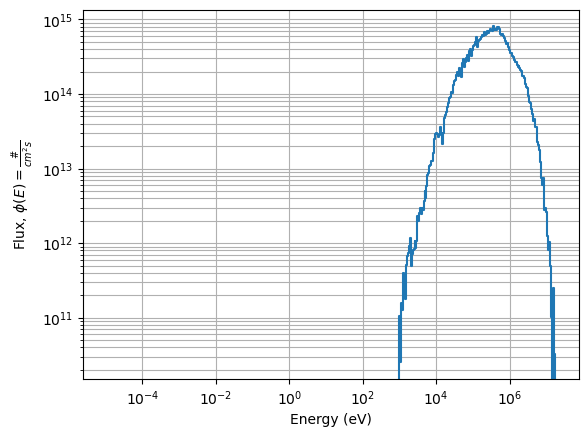

In [32]:
# Neutron spectrum
spectrum_tally = sp.get_tally(name = "Neutron Spectrum")

e_filter = spectrum_tally.filters[0]
E = e_filter.bins[:,0]

spectrum_mean = spectrum_tally.get_values(value = 'mean').ravel()
spectrum_std_dev = spectrum_tally.get_values(value = 'std_dev').ravel()

# Plot
fig, ax = plt.subplots()
plt.errorbar(E, spectrum_mean*2.77*10**(14),spectrum_std_dev, ds = 'steps')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Energy (eV)")
ax.set_ylabel(r"Flux, $\phi(E)=\frac{\#}{cm^2s}$")
ax.grid(True, which = 'both')

In [33]:
print(np.max(spectrum_mean))

2.9167061044018636
